In [1]:
import paragami

import autograd
from autograd import numpy as np
import copy

# Use the original scipy for functions we don't need to differentiate.
import scipy as osp

In [2]:
np.random.seed(42)

num_obs = 500
data_dim = 3

# True values of parameters
true_sigma = \
    np.eye(3) * np.diag(np.arange(0, data_dim)) + \
    np.random.random((data_dim, data_dim)) * 0.1
true_sigma = 0.5 * (true_sigma + true_sigma.T)
true_mu = np.arange(0, data_dim)

true_norm_param_dict = dict()
true_norm_param_dict['mu'] = true_mu
true_norm_param_dict['sigma'] = true_sigma

# Data
data = np.random.multivariate_normal(
    mean=true_norm_param_dict['mu'],
    cov=true_norm_param_dict['sigma'],
    size=(num_obs, ))

In [20]:
def get_mvn_log_probs(obs, mean, cov):
    cov_inv = np.linalg.inv(cov)
    cov_det_sign, cov_log_det = np.linalg.slogdet(cov)
    if cov_det_sign <= 0:
        return np.full(float('inf'), obs.shape[0])
    else:
        obs_centered = obs - np.expand_dims(mean, axis=0)
        return -0.5 * (
            np.einsum('ni,ij,nj->n', obs_centered, cov_inv, obs_centered) + \
            cov_log_det)

def get_data_lp(data, norm_param_dict, weights):
    data_lp = np.sum(weights *
                     get_mvn_log_probs(
                         data,
                         mean=norm_param_dict['mu'],
                         cov=norm_param_dict['sigma']))
    return data_lp

def get_prior_lp(norm_param_dict, prior_param_dict):
    data_dim = len(prior_param_dict['prior_mean']) 
    prior_cov = np.eye(data_dim) * prior_param_dict['prior_sd']
    prior_lp = get_mvn_log_probs(
        obs=np.expand_dims(norm_param_dict['mu'], axis=0),
        mean=prior_param_dict['prior_mean'],
        cov=prior_cov)

    # Sum so as to return a scalar.
    return np.sum(prior_lp)

def get_loss(data, norm_param_dict, prior_param_dict, weights):
    return -1 * (get_prior_lp(norm_param_dict, prior_param_dict) +
                 get_data_lp(data, norm_param_dict, weights))
    
class NormalModel():
    def __init__(self, data):
        self.data = data
        self.num_obs = self.data.shape[0]
        self.data_dim = self.data.shape[1]
                
        # Reasonable defaults for the priors and weights.
        self.set_prior(np.full(self.data_dim, 0.), 10)
        self.set_weights(np.full(self.num_obs, 1.0))
                
    def set_weights(self, weights):
        self.weights = weights
    
    def set_prior(self, prior_mean, prior_sd):
        self.prior_dict = dict()
        self.prior_dict['prior_mean'] = prior_mean
        self.prior_dict['prior_sd'] = prior_sd

    def get_loss_for_opt(self, norm_param_dict):
        return get_loss(
            self.data, norm_param_dict, self.prior_dict, self.weights)
    
    def get_loss_by_prior(self, norm_param_dict, prior_dict):
        return get_loss(
            self.data, norm_param_dict, prior_dict, self.weights)

    def get_loss_by_weights(self, norm_param_dict, weights):
        return get_loss(
            self.data, norm_param_dict, self.prior_dict, weights)

    
model = NormalModel(data)
orig_prior_dict = copy.deepcopy(model.prior_dict)
print('Loss at true parameter: {}'.format(model.get_loss_for_opt(true_norm_param_dict)))

Loss at true parameter: 66.51345919899458


Define patterns.

In [25]:
norm_pattern = paragami.PatternDict()
norm_pattern['mu'] = paragami.NumericArrayPattern(shape=(data_dim, ))
norm_pattern['sigma'] = paragami.PSDMatrixPattern(size=data_dim)

prior_pattern = paragami.PatternDict()
prior_pattern['prior_mean'] = paragami.NumericArrayPattern(shape=(data_dim, ))
prior_pattern['prior_sd'] = paragami.NumericArrayPattern(shape=(1, ), lb=0.0)

weight_pattern = paragami.NumericArrayPattern(shape=(num_obs, ))

In [26]:
# Optimize.
opt_fun = paragami.FlattenedFunction(
    original_fun=model.get_loss_for_opt,
    patterns=norm_pattern,
    free=True)
opt_fun_grad = autograd.grad(opt_fun)
opt_fun_hessian = autograd.hessian(opt_fun)

def get_optimum(init_param):
    return osp.optimize.minimize(
        method='trust-ncg',
        x0=init_param,
        fun=opt_fun,
        jac=opt_fun_grad,
        hess=opt_fun_hessian,
        options={'gtol': 1e-8, 'disp': True})

# Initialize with zeros.
init_param = np.zeros(norm_pattern.flat_length(free=True))
mle_opt = get_optimum(init_param)

         Current function value: 61.949845
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 17
         Hessian evaluations: 17


In [27]:
opt_norm_param_dict = norm_pattern.fold(mle_opt.x, free=True)
print(opt_norm_param_dict)
print(true_norm_param_dict)

OrderedDict([('mu', array([0.00834318, 0.95331727, 1.89785702])), ('sigma', array([[0.03865699, 0.08549517, 0.03813799],
       [0.08549517, 1.05532374, 0.09781211],
       [0.03813799, 0.09781211, 1.91488878]]))])
{'sigma': array([[0.03745401, 0.07746864, 0.03950388],
       [0.07746864, 1.01560186, 0.05110853],
       [0.03950388, 0.05110853, 2.0601115 ]]), 'mu': array([0, 1, 2])}


In [28]:
prior_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=model.get_loss_by_prior,
        opt_par_pattern=norm_pattern,
        hyper_par_pattern=prior_pattern,
        opt_par_folded_value=opt_norm_param_dict,
        hyper_par_folded_value=model.prior_dict,
        validate_optimum=False,
        opt_par_is_free=True,
        hyper_par_is_free=False)

AttributeError: 'int' object has no attribute 'flatten'

In [8]:
# This helper function lets us easily see the differences in parameters.
def get_norm_param_diff(par1, par2):
    diff = \
        norm_pattern.flatten(par1, free=False, validate=False) - \
        norm_pattern.flatten(par2, free=False, validate=False)
    return norm_pattern.fold(diff, free=False, validate=False)

In [9]:
# Change the prior.
new_prior_dict = copy.deepcopy(orig_prior_dict)
change_mean = False
change_cov = True
if change_mean:
    new_prior_dict['prior_mean'] = orig_prior_dict['prior_mean'] + 10
if change_cov:
    new_prior_dict['prior_cov'] = 0.001 * orig_prior_dict['prior_cov']

# Get the linear prediction at the new prior.
pred_norm_param_dict = \
    prior_sens.predict_opt_par_from_hyper_par(new_prior_dict)

# Re-optimize to check the prior sensitivity.
model.prior_dict = new_prior_dict
new_opt_par = get_optimum(norm_pattern.flatten(opt_norm_param_dict, free=True))
new_norm_param_dict = norm_pattern.fold(new_opt_par.x, free=True)


         Current function value: 212.694887
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 13
         Hessian evaluations: 13


In [10]:
# Look at the differences.
pred_diff = get_norm_param_diff(
    pred_norm_param_dict, opt_norm_param_dict)
true_diff = get_norm_param_diff(
    new_norm_param_dict, opt_norm_param_dict)
for param in ['mu', 'sigma']:
    print('Predicted {} differences:\n{}'.format(param, pred_diff[param]))
    print('Actual {} differences:\n{}'.format(param, true_diff[param]))


Predicted mu differences:
[-3.08005884e-05 -2.38177322e-04 -7.44514769e-04]
Actual mu differences:
[-0.02730183 -0.22125823 -0.62122988]
Predicted sigma differences:
[[1.89986626e-09 1.46910782e-08 4.59252342e-08]
 [1.46910782e-08 1.13601566e-07 3.55125641e-07]
 [4.59252342e-08 3.55125641e-07 1.11014540e-06]]
Actual sigma differences:
[[0.00074707 0.00605409 0.01700023]
 [0.00605409 0.04906074 0.13776533]
 [0.01700023 0.13776533 0.38685287]]


OrderedDict:
	[prior_mean] = Array (3,) (lb=-inf, ub=inf)
	[prior_cov] = PDMatrix 3x3 (diag_lb = 0.0)
OrderedDict:
	[mu] = Array (3,) (lb=-inf, ub=inf)
	[sigma] = PDMatrix 3x3 (diag_lb = 0.0)


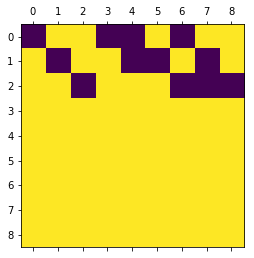

In [19]:
cross_hess = prior_sens._hyper_obj_cross_hess(prior_sens._opt0, prior_sens._hyper0)
plt.matshow(cross_hess == 0)
print(prior_pattern)
print(norm_pattern)

[[ 7.73098959e-06  1.70951517e-05  7.62429175e-06  6.45010172e-09
   7.51271374e-07  1.62971032e-06  1.47359237e-06  3.97125225e-06
   1.44698156e-06]
 [ 1.70951517e-05  2.11019615e-04  1.95507177e-05  1.42627882e-08
   1.80576773e-06  2.01168643e-05  3.26072686e-06  4.19123095e-05
   3.71044667e-06]
 [ 7.62429175e-06  1.95507177e-05  3.82830937e-04  6.36108182e-09
   7.43148407e-07  1.86380367e-06  1.76638420e-06  4.02063809e-05
   7.26558381e-05]
 [-6.16795395e-09 -1.36388889e-08 -6.08282805e-09 -5.14603337e-12
  -5.99380867e-10 -1.30021883e-09 -1.17566448e-09 -3.16835260e-09
  -1.15443379e-09]
 [-9.37677144e-09 -4.79058450e-08 -9.66955615e-09 -7.82320670e-12
  -9.33872507e-10 -4.56694692e-09 -1.78764463e-09 -1.00136599e-08
  -1.83514350e-09]
 [ 5.85992030e-13 -3.40470418e-08 -5.28473198e-10  4.88903543e-16
  -2.83501871e-11 -3.24576328e-09 -3.29701652e-13 -6.51202198e-09
  -1.00296657e-10]
 [-2.93150572e-08 -6.52451202e-08 -8.77829502e-08 -2.44580721e-11
  -2.84909018e-09 -6.2199299

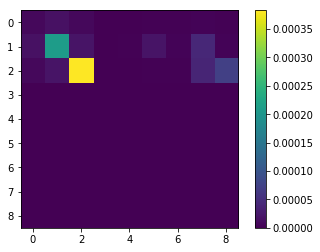

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Note: it does not seem to be working for sigma.

print(prior_sens.get_dopt_dhyper())

plt.imshow(prior_sens.get_dopt_dhyper())
plt.colorbar()
